# **Introduction:**

This file serves to perform a grid search to determine a baseline for the best hyperparameters for an ANN model for use in multi-robot task allocation through regression on FIS-generated data. The goal for designing this ANN is to compare its performance against an ANFIS to determine which is better at approximating the FIS, which will be achieved through using the coefficient of determination ($R^{2}$), root mean squared error (RMSE), and mean absolute error (MAE).

**Date Created:** 12/12/2024

**Date Modified:** 18/12/2024


# **Import Packages:**

This section imports all necessary packages for the ANN implementation.

In [1]:
# import packages:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import json

# **Data Loading & Discovery:**

This section loads the data that was generated from the FIS. 

In [2]:
# get the path to the data CSV:
files_in_dir = os.listdir(os.getcwd())
data_path = os.path.join(os.getcwd(), files_in_dir[files_in_dir.index('V3_Data.csv')])
print(f"data path is: {data_path}")

# load the CSV as a pandas dataframe:
df = pd.read_csv(data_path)
print(f"data successfully loaded")

# inspect some members of the dataframe:
print(f"dataframe shape is: {df.shape}")
print(f"columns are: {list(df.columns)}\n")
df.head()

data path is: c:\Users\mtidd2\Desktop\Research\Inference Systems\Python_Design\ANN_Design\ANN_GridSearch_V1\V3_Data.csv
data successfully loaded
dataframe shape is: (10000, 4)
columns are: ['Load History', 'Distance to Task', 'Total Distance Travelled', 'Suitability']



,Load History,Distance to Task,Total Distance Travelled,Suitability
0,5.0,24.0,20.0,3.234294
1,6.0,6.0,20.0,4.794328
2,5.0,1.0,4.0,7.095916
3,10.0,8.0,22.0,3.457732
4,2.0,6.0,0.0,7.085754


Going to check the distribution of each input variable, as well as the suitability:

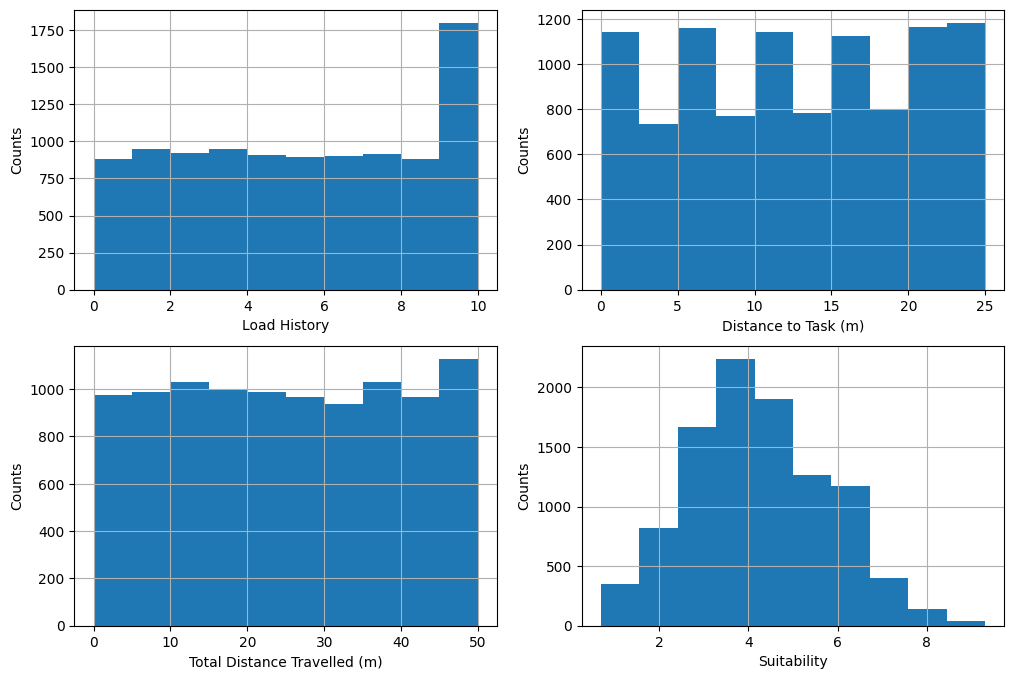

In [3]:
# get histogram of each column:
fig = plt.figure(figsize = (12,8))
plt.subplot(2,2,1)
df['Load History'].hist()
plt.xlabel('Load History')
plt.ylabel('Counts')
plt.subplot(2,2,2)
df['Distance to Task'].hist()
plt.xlabel('Distance to Task (m)')
plt.ylabel('Counts')
plt.subplot(2,2,3)
df['Total Distance Travelled'].hist()
plt.xlabel('Total Distance Travelled (m)')
plt.ylabel('Counts')
plt.subplot(2,2,4)
df['Suitability'].hist()
plt.xlabel('Suitability')
plt.ylabel('Counts')
plt.show()

# **Pre-process Data:**

This section will split the data into training, validation, and testing, alongside performing some pre-processing.

In [4]:
# get feature and label dataframes:
x_data = df.drop(['Suitability'], axis = 1)
y_data = df['Suitability']

Need to first standardize the values:

In [5]:
# define scaler:
scaler = StandardScaler()
x_data_scaled = scaler.fit_transform(x_data)

Split data into training, validation, and testing:

In [6]:
# split dataset:
x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5)

# get split results:
print(f"there are {x_train.shape[0]} training examples")
print(f"there are {x_val.shape[0]} validation examples")
print(f"there are {x_test.shape[0]} testing examples")

# get input shape:
INPUT_SHAPE = x_data.shape[1]

there are 8000 training examples
there are 1000 validation examples
there are 1000 testing examples


# **Model Exploration:**

Within this section, a function is defined for instantiating models using the Keras API, for use in performing a hyperparameter search to determine the best combination of hyperparameters. The hyperparameters that are being considered are:

* number of hidden layers
* number of hidden neurons
* number of epochs
* learning rate
* using batch normalization vs. not using batch normalization
* using dropout vs. not using dropout
* activation function
* batch size

In [7]:
# query user for whether they want to grid search:
grid_search = input('perform grid search? (True/False)')

if grid_search.strip().lower() == 'true':
    grid_search = True

    # define parameter values to be explored:
    num_hidden_layers = [1, 2]
    num_hidden_neurons = [16, 32, 64]
    num_epochs = [100, 250, 500]
    learning_rates = [0.001, 0.0005, 0.0001]
    batch_sizes = [32, 64, 128]

    combinations = len(num_hidden_layers) * len(num_hidden_neurons) * len(num_epochs) * len(learning_rates) * len(batch_sizes)

    LOSS_FUNCTION = 'mse'
    METRICS = ['mae', keras.metrics.RootMeanSquaredError(), keras.metrics.R2Score()]
else: 
    grid_search = False

Define a model generation function:

In [8]:
# define function:
def make_model(layers, neurons, rate, norm, drop):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (INPUT_SHAPE, )))
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        
        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))
        
        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
        
    # add output layer:
    model.add(Dense(1, activation = 'linear', name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = LOSS_FUNCTION,
                  metrics = METRICS)
    
    return model

Now we must perform the grid search. This process entails:

* Creating a directory to save the search results in
* Creating a model using the aforementioned "make_model()" function
* Save the parameters used in the creation of the model within dictionary called "model_params"
* Train the model, saving results into a dictionary called "training results"
* Combining the training parameters with the training results into a JSON dump

While iterating through each combination of parameters.

In [9]:
if grid_search == True:
    j = 1
    # set up grid search:
    for layer in num_hidden_layers:
        for neurons in num_hidden_neurons:
            for epochs in num_epochs:
                for rate in learning_rates:
                        for batch in batch_sizes:

                            # update user:
                            print(f"examining model {j}/{combinations}", end = '\r')
                            j += 1

                            # make directory to save into:
                            output_dir = os.path.join(os.getcwd(), f"ann_search_results//{str(layer)}_{str(neurons)}_{str(epochs)}_{str(rate)}_{str(batch)}")
                            os.makedirs(output_dir, exist_ok = True)

                            # build a model:
                            tf.keras.backend.clear_session()
                            model = make_model(layer, neurons, rate, True, True)

                            # save training parameters into a dictionary:
                            training_params = {
                                'num_layers' : layer,
                                'num_neurons' : neurons,
                                'num_epochs' : epochs,
                                'learning_rate' : rate,
                                'use_batch_norm' : True,
                                'use_dropout' : True,
                                'batch_size' :  batch
                            }

                            # train model:
                            train_start = time.time()
                            history = model.fit(x_train, y_train, 
                                                epochs = epochs,
                                                batch_size = batch,
                                                validation_data = [x_val, y_val],
                                                verbose = 0
                                                )
                            train_time = time.time() - train_start

                            # store training results:
                            training_results = {}
                            for i in history.history.keys():
                                training_results[i] = history.history[i][-1]
                            training_results['train_time'] = train_time

                            # save both results to a directory:
                            params_path = os.path.join(output_dir, "params_results.json")
                            with open(params_path, "w") as f:
                                json.dump({'parameters': training_params, 'results': training_results}, f, indent = 4)               

# **Examine Hyperparameter Search Results:**

This section examines the data that was collected during the hyperparameter grid search. Each combination of hyperparameters had its training parameters and training results saved into seperate dictionaries, which were then concatenated into a JSON dump. This section pertains to iterating through each of the folders of the tests and amalgamating the results into a Pandas DataFrame for further analysis:

In [10]:
# initialize results list:
results = []
grid_search_folder = os.path.join(os.getcwd(), "ann_search_results")

for folder in os.listdir(grid_search_folder):
    folder_path = os.path.join(grid_search_folder, folder)
    if os.path.isdir(folder_path):
        params_file = os.path.join(folder_path, 'params_results.json')

        if os.path.exists(params_file):
            with open(params_file, 'r') as f:
                data = json.load(f)

                # flatten the JSON:
                extracted_data = {
                    # training params:
                    'num_layers' : data['parameters']['num_layers'],
                    'num_neurons' : data['parameters']['num_neurons'],
                    'num_epochs' : data['parameters']['num_epochs'],
                    'learning_rate' : data['parameters']['learning_rate'],
                    'batch_size' : data['parameters']['batch_size'],

                    # training results:
                    'train_loss' : data['results']['loss'],
                    'train_mae' : data['results']['mae'],
                    'train_rmse' : data['results']['root_mean_squared_error'],
                    'training_r2' : data['results']['r2_score'],
                    'val_loss' : data['results']['val_loss'],
                    'val_mae' : data['results']['val_mae'],
                    'val_rmse' : data['results']['val_root_mean_squared_error'],
                    'val_r2' : data['results']['val_r2_score'],
                    'training_time' : data['results']['train_time']    
                }

                results.append(extracted_data)

# turn the results into a dataframe:
results_df = pd.DataFrame(results)

# insert an identifier for models:
results_df.insert(0, 'model_name', [f"model {index+1}" for index, row in results_df.iterrows()])

# save consolidated data into CSV file:
results_df.to_csv("consolidated_results.csv", index = False)

Need to now determine the best hyperparameter combination based on the results from this analysis, which have been consolidated into a single DataFrame. Going to organize the DataFrame by the best of each metric. The metrics that will be examined are:

* Training MSE (loss)
* Validation MSE (loss)
* Validation MAE
* Validation RMSE
* Validation $R^{2}$

Sort the consolidated results by the lowest training loss:

In [11]:
results_df.sort_values(by = 'train_loss', ascending = True).head(15)

,model_name,num_layers,num_neurons,num_epochs,learning_rate,batch_size,train_loss,train_mae,train_rmse,training_r2,val_loss,val_mae,val_rmse,val_r2,training_time
159,model 160,2,64,500,0.0010,128,0.098986,0.245515,0.314621,0.959498,0.026640,0.126827,0.163219,0.989415,37.319488
156,model 157,2,64,500,0.0005,128,0.119826,0.270029,0.346158,0.950972,0.028068,0.124681,0.167535,0.988847,37.715073
150,model 151,2,64,250,0.0010,128,0.120548,0.270946,0.347200,0.950676,0.036528,0.149188,0.191123,0.985486,19.189358
161,model 162,2,64,500,0.0010,64,0.124772,0.274505,0.353231,0.948948,0.022614,0.116722,0.150378,0.991015,49.206192
132,model 133,2,32,500,0.0010,128,0.126984,0.276231,0.356348,0.948043,0.049774,0.172104,0.223101,0.980223,35.096962
158,model 159,2,64,500,0.0005,64,0.127343,0.280353,0.356851,0.947896,0.023078,0.116047,0.151914,0.990830,50.164214
147,model 148,2,64,250,0.0005,128,0.136693,0.288285,0.369720,0.944070,0.033203,0.139278,0.182217,0.986807,19.349796
78,model 79,1,64,500,0.0010,128,0.137399,0.290526,0.370674,0.943781,0.069990,0.211597,0.264556,0.972190,31.582975
157,model 158,2,64,500,0.0005,32,0.141363,0.297802,0.375983,0.942160,0.022541,0.114416,0.150135,0.991044,78.758524
152,model 153,2,64,250,0.0010,64,0.141995,0.294381,0.376822,0.941901,0.026632,0.124596,0.163195,0.989418,25.313470


Sort the consolidated results by lowest validation loss:

In [12]:
results_df.sort_values(by = 'val_loss', ascending = True).head(15)

,model_name,num_layers,num_neurons,num_epochs,learning_rate,batch_size,train_loss,train_mae,train_rmse,training_r2,val_loss,val_mae,val_rmse,val_r2,training_time
160,model 161,2,64,500,0.0010,32,0.158514,0.314569,0.398139,0.935141,0.022074,0.114892,0.148572,0.991229,79.207278
148,model 149,2,64,250,0.0005,32,0.164127,0.319594,0.405125,0.932846,0.022370,0.114278,0.149565,0.991112,38.916411
157,model 158,2,64,500,0.0005,32,0.141363,0.297802,0.375983,0.942160,0.022541,0.114416,0.150135,0.991044,78.758524
161,model 162,2,64,500,0.0010,64,0.124772,0.274505,0.353231,0.948948,0.022614,0.116722,0.150378,0.991015,49.206192
158,model 159,2,64,500,0.0005,64,0.127343,0.280353,0.356851,0.947896,0.023078,0.116047,0.151914,0.990830,50.164214
152,model 153,2,64,250,0.0010,64,0.141995,0.294381,0.376822,0.941901,0.026632,0.124596,0.163195,0.989418,25.313470
159,model 160,2,64,500,0.0010,128,0.098986,0.245515,0.314621,0.959498,0.026640,0.126827,0.163219,0.989415,37.319488
149,model 150,2,64,250,0.0005,64,0.143492,0.296504,0.378803,0.941288,0.027086,0.128508,0.164578,0.989238,25.213449
156,model 157,2,64,500,0.0005,128,0.119826,0.270029,0.346158,0.950972,0.028068,0.124681,0.167535,0.988847,37.715073
151,model 152,2,64,250,0.0010,32,0.161308,0.315899,0.401632,0.933999,0.028655,0.130114,0.169279,0.988614,38.930453


Sort the consolidated results by the lowest validation MAE:

In [13]:
results_df.sort_values(by = 'val_mae', ascending = True).head(5)

,model_name,num_layers,num_neurons,num_epochs,learning_rate,batch_size,train_loss,train_mae,train_rmse,training_r2,val_loss,val_mae,val_rmse,val_r2,training_time
148,model 149,2,64,250,0.0005,32,0.164127,0.319594,0.405125,0.932846,0.022370,0.114278,0.149565,0.991112,38.916411
157,model 158,2,64,500,0.0005,32,0.141363,0.297802,0.375983,0.942160,0.022541,0.114416,0.150135,0.991044,78.758524
160,model 161,2,64,500,0.0010,32,0.158514,0.314569,0.398139,0.935141,0.022074,0.114892,0.148572,0.991229,79.207278
158,model 159,2,64,500,0.0005,64,0.127343,0.280353,0.356851,0.947896,0.023078,0.116047,0.151914,0.990830,50.164214
161,model 162,2,64,500,0.0010,64,0.124772,0.274505,0.353231,0.948948,0.022614,0.116722,0.150378,0.991015,49.206192


Sort the consolidated results by the lowest validation RMSE:

In [14]:
results_df.sort_values(by = 'val_rmse', ascending = True).head(5)

,model_name,num_layers,num_neurons,num_epochs,learning_rate,batch_size,train_loss,train_mae,train_rmse,training_r2,val_loss,val_mae,val_rmse,val_r2,training_time
160,model 161,2,64,500,0.0010,32,0.158514,0.314569,0.398139,0.935141,0.022074,0.114892,0.148572,0.991229,79.207278
148,model 149,2,64,250,0.0005,32,0.164127,0.319594,0.405125,0.932846,0.022370,0.114278,0.149565,0.991112,38.916411
157,model 158,2,64,500,0.0005,32,0.141363,0.297802,0.375983,0.942160,0.022541,0.114416,0.150135,0.991044,78.758524
161,model 162,2,64,500,0.0010,64,0.124772,0.274505,0.353231,0.948948,0.022614,0.116722,0.150378,0.991015,49.206192
158,model 159,2,64,500,0.0005,64,0.127343,0.280353,0.356851,0.947896,0.023078,0.116047,0.151914,0.990830,50.164214


Sort the consolidated results by the highest validation $R^{2}$:

In [15]:
results_df.sort_values(by = 'val_r2', ascending = False).head(5)

,model_name,num_layers,num_neurons,num_epochs,learning_rate,batch_size,train_loss,train_mae,train_rmse,training_r2,val_loss,val_mae,val_rmse,val_r2,training_time
160,model 161,2,64,500,0.0010,32,0.158514,0.314569,0.398139,0.935141,0.022074,0.114892,0.148572,0.991229,79.207278
148,model 149,2,64,250,0.0005,32,0.164127,0.319594,0.405125,0.932846,0.022370,0.114278,0.149565,0.991112,38.916411
157,model 158,2,64,500,0.0005,32,0.141363,0.297802,0.375983,0.942160,0.022541,0.114416,0.150135,0.991044,78.758524
161,model 162,2,64,500,0.0010,64,0.124772,0.274505,0.353231,0.948948,0.022614,0.116722,0.150378,0.991015,49.206192
158,model 159,2,64,500,0.0005,64,0.127343,0.280353,0.356851,0.947896,0.023078,0.116047,0.151914,0.990830,50.164214


Sort the consolidated results by lowest training loss, validation loss, validation MAE, validation RMSE, and highest validation $R^{2}$:

In [16]:
results_df.sort_values(by = ['train_loss', 'val_loss', 'val_mae', 'val_rmse', 'val_r2'], ascending = [True, True, True, True, False]).head(3)

,model_name,num_layers,num_neurons,num_epochs,learning_rate,batch_size,train_loss,train_mae,train_rmse,training_r2,val_loss,val_mae,val_rmse,val_r2,training_time
159,model 160,2,64,500,0.0010,128,0.098986,0.245515,0.314621,0.959498,0.026640,0.126827,0.163219,0.989415,37.319488
156,model 157,2,64,500,0.0005,128,0.119826,0.270029,0.346158,0.950972,0.028068,0.124681,0.167535,0.988847,37.715073
150,model 151,2,64,250,0.0010,128,0.120548,0.270946,0.347200,0.950676,0.036528,0.149188,0.191123,0.985486,19.189358


# **Results & Conclusions - Grid Search V1:**

From this analysis it can be seen that the best performing model was that of ***model 160***, which had two layers, each with 64 neurons, and was trained for 500 epochs using a learning rate of 0.001 and a batch size of 128. This model had the lowest training loss, meaning that it performed quite well on the dataset provided, and seeing as the validation loss was lower than the training loss, it was able to generalize to the unseen data. 

Generally, when examining the best models, it was found that the top 5 performing models in terms of training loss were those that had the following structure:

* 2 layers
* 64 neurons per layer
* trained for 500 epochs
* learning rate between 0.0005 and 0.001
* batch size > 64

Similarly, the top 5 performing models in terms of the validation loss were those that had the following structure:

* 2 layers
* 64 neurons per layer
* trained for 500 epochs
* batch size > 64

When examining the validation MAE, RMSE, and $R^{2}$ value, it can be seen that the best performing models were those that had a similar structure. This analysis was beneficial as it allowed for a deeper dive into selecting the best hyperparameters. Further work will include examining further the effects of increasing the number of layers, as well as the neurons per layer, and even having varying amounts of neurons per layer.